# Transcription Factor Project - Differential Expression Analysis and Minimum Distortion Embedding
**Robin Anwyl, UCSD Subramaniam Lab**

**Goal:** Analyze the hiPSC Perturb-seq dataset from the Mali lab (Nourreddine et al 2023 preprint) to investigate the effects of transcription factor knockouts (TF KDs)

**Guiding Questions:** What do TF KD effects reveal about:
* … the transcription regulatory network of hiPSCs, and TF crosstalk?
* … cell lineage?
* … how TFs influence chromatin remodeling?

# Import statements

In [1]:
# Using psp_env virtual environment
import sys
import os
repo_root = "/home/ranwyl/KOLF2.1J_Perturbation_Cell_Atlas/"
if repo_root not in sys.path:
    sys.path.insert(0, "/home/ranwyl/KOLF2.1J_Perturbation_Cell_Atlas/")

import psp
import gc
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'DejaVu Sans'

# Differential expression analysis

We will carry out differential expression analysis at the gRNA level with PyDESeq2 using a pseudobulk method.

## Check for ~75% genome coverage and filter genes

In [14]:
data_path = "/home/ranwyl/data_tf_project/KOLF_Pan_Genome_Alpha_CPMnorm_Knockdown_Energy_Test_Filtered.h5ad"
adata = psp.utils.read_anndata(data_path)
adata

AnnData object with n_obs × n_vars = 101923 × 20043
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'perturbation', 'gene_target_ensembl_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'perturbation_edist', 'perturbation_pvalue', 'perturbation_significant'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'etest_results', 'etest_results_params'
    layers: 'counts'

In [3]:
# Genome coverage testing
import numpy as np
import anndata as ad
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
plt.rcParams.update({'font.size': 12})

def compute_genome_coverage_for_gRNA_pseudoreps(adata: ad.AnnData, gRNA: str, 
                                                rng: np.random.Generator,
                                                include_total: bool=True) -> dict:
    """
    Generate differential expression analysis pseudoreplicates for the given gRNA
    and compute genome coverage (number of genes expressed in rep divided by
    number of genes in dataset).
    """
    data_matrix = adata.X
    total_n_genes = adata.shape[1]
    genome_coverage = list() # n genes expressed in rep/n genes in adata
    # Create gRNA pseudoreplicates
    gRNA_indices = np.where(adata.obs['gRNA'] == gRNA)[0]
    n_cells = len(gRNA_indices)
    n_reps = 2 if n_cells <= 35 else 3
    rep_size = len(gRNA_indices) // n_reps
    sample_size = rep_size * n_reps
    sampled_gRNA_indices = rng.choice(gRNA_indices, sample_size, replace=False)
    # Number of expressed genes for all cells that received this gRNA
    gRNA_profile = data_matrix[sampled_gRNA_indices].sum(axis=0)
    gRNA_n_expr_genes = np.count_nonzero(gRNA_profile)
    # Compute genome coverage for each rep
    for rep in range(n_reps):
        # Number of expressed genes in rep
        start, stop = rep*rep_size, (rep+1)*rep_size
        rep_indices = sampled_gRNA_indices[start:stop]
        rep_profile = data_matrix[rep_indices].sum(axis=0)
        rep_n_expr_genes = np.count_nonzero(rep_profile)
        # Genome coverage
        rep_genome_coverage = np.round(rep_n_expr_genes / total_n_genes, 2)
        genome_coverage.append(rep_genome_coverage)
    # If no 3rd rep, add NaN value
    if len(genome_coverage) == 2:
        genome_coverage.append(np.nan)
    # Add total
    if include_total == True:
        total_genome_coverage = np.round(gRNA_n_expr_genes / total_n_genes, 2)
        genome_coverage.append(total_genome_coverage)
    # Return results
    return genome_coverage

def build_DE_gRNA_rep_genome_coverage_df(adata: ad.AnnData, n_cells_per_gRNA: list = [], 
                                    n_gRNA_per_size: int = 0, gRNA_list: list = [],
                                    random_state: int=42, include_total: bool=True,
                                    n_reps: int=3):
    """
    For each of the given numbers of cells per gRNA, sample a given number of gRNA,
    generate differential expression analysis pseudoreplicates for each gRNA,
    and compute genome coverage (number of genes expressed in rep divided by
    number of genes in dataset).
    """
    # Check that necessary inputs are provided
    if n_cells_per_gRNA != [] and n_gRNA_per_size == 0:
        print("Error: must provide number of gRNA to sample per size (cell number)")
    if n_cells_per_gRNA == [] and n_gRNA_per_size != 0:
        print("Error: must provide list of gRNA cell numbers")
    if n_cells_per_gRNA == [] and gRNA_list == []:
        print("Error: must provide list of gRNA or gRNA cell numbers")

    # Subset only KD cells and reset adata.X to counts
    adata = adata[adata.obs.perturbed == "True"].copy()
    adata.X = adata.layers["counts"].copy()

    # Build DF of number of cells per gRNA
    cells_per_gRNA = adata.obs.gRNA.value_counts()
    cells_per_gRNA = cells_per_gRNA.rename_axis("gRNA").reset_index(name="n_cells")

    # Generate RNG objects
    rng = np.random.default_rng(random_state)
    rngs = rng.spawn(2)
    gRNA_rng, reps_rng = rngs[0], rngs[1]
    
    # Initialize dict for genome coverage
    genome_coverage_dict = dict()

    # If a gRNA list is not provided, randomly sample gRNA
    if gRNA_list == []:
        # Loop through desired sizes of cells, e.g. [25, 30)
        for i in range(len(n_cells_per_gRNA)-1):
            # Filter to only gRNA with desired number of cells
            min_n_cells, max_n_cells = n_cells_per_gRNA[i], n_cells_per_gRNA[i+1]
            print(f"Sampling gRNA with {min_n_cells}-{max_n_cells-1} cells")
            filt_cells_per_gRNA = \
                cells_per_gRNA[(cells_per_gRNA["n_cells"] >= min_n_cells) & 
                (cells_per_gRNA["n_cells"] < max_n_cells)].copy()
            # If DF is empty, skip this cell number
            if filt_cells_per_gRNA.empty:
                continue
            # If number of gRNA > desired number, sample randomly
            if filt_cells_per_gRNA.shape[0] > n_gRNA_per_size:
                all_gRNA_indices = filt_cells_per_gRNA.index.tolist()
                chosen_gRNA_indices = gRNA_rng.choice(all_gRNA_indices, n_gRNA_per_size,
                                        replace=False)
                filt_cells_per_gRNA = \
                    filt_cells_per_gRNA[filt_cells_per_gRNA.index.isin(chosen_gRNA_indices)].copy()
            # Build gRNA list
            filt_cells_per_gRNA.sort_values(by="n_cells", inplace=True)
            gRNA_list += filt_cells_per_gRNA["gRNA"].tolist()
    else: # Sort gRNA list by number of cells per gRNA
        filt_cells_per_gRNA = cells_per_gRNA[cells_per_gRNA["gRNA"].isin(gRNA_list)].copy()
        filt_cells_per_gRNA.sort_values(by="n_cells", inplace=True)
        gRNA_list = filt_cells_per_gRNA["gRNA"].tolist()

    # For all gRNA, generate pseudoreps and calculate genome coverage
    for i in tqdm(range(len(gRNA_list)), desc="Computing genome coverage for gRNA"):
        gRNA = gRNA_list[i]
        # Get number of cells for gRNA
        gRNA_idx = cells_per_gRNA[cells_per_gRNA["gRNA"] == gRNA].index[0]
        gRNA_n_cells = cells_per_gRNA.at[gRNA_idx, "n_cells"]
        gRNA_entry = f"{gRNA} ({gRNA_n_cells} cells)"
        # Compute genome and gRNA gene coverage for pseudoreps
        genome_coverage_list = \
            compute_genome_coverage_for_gRNA_pseudoreps(adata, gRNA, reps_rng, include_total)
        genome_entry = {f"rep{i+1}": genome_coverage_list[i] for i in range(n_reps)}
        if include_total == True:
            genome_entry["total"] = genome_coverage_list[-1]
        genome_coverage_dict[gRNA_entry] = genome_entry
    
    # Build DFs
    genome_coverage_df = pd.DataFrame.from_dict(genome_coverage_dict, orient="index")
    return genome_coverage_df

def plot_gene_coverage_heatmap(genome_coverage_df: pd.DataFrame, title: str,
                               cmap: str="viridis", annot: bool=True,
                               figsize: tuple=(3,8)):
    plt.figure(figsize=figsize)
    nan_mask = genome_coverage_df.isna()
    ax = sns.heatmap(genome_coverage_df, cmap=cmap, annot=annot, annot_kws={"size": 8},
        mask=nan_mask, vmin=0, vmax=1, linewidths=0.5, xticklabels=True)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=10)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=10)
    plt.grid(False)
    plt.title(title, pad=10, fontsize=12)
    plt.show()

Sample 5 gRNA of each size [25, 30, 35, 40, 45, 50] cells. See if each pseudoreplicate achieves 75% genome coverage.

In [15]:
gRNA_genome_coverage_df = build_DE_gRNA_rep_genome_coverage_df(adata, 
    n_cells_per_gRNA = [25, 30, 35, 40, 45, 50], n_gRNA_per_size=5,
    include_total=False, random_state=12345)

Computing genome coverage for gRNA: 100%|██████████| 25/25 [00:43<00:00,  1.74s/it]


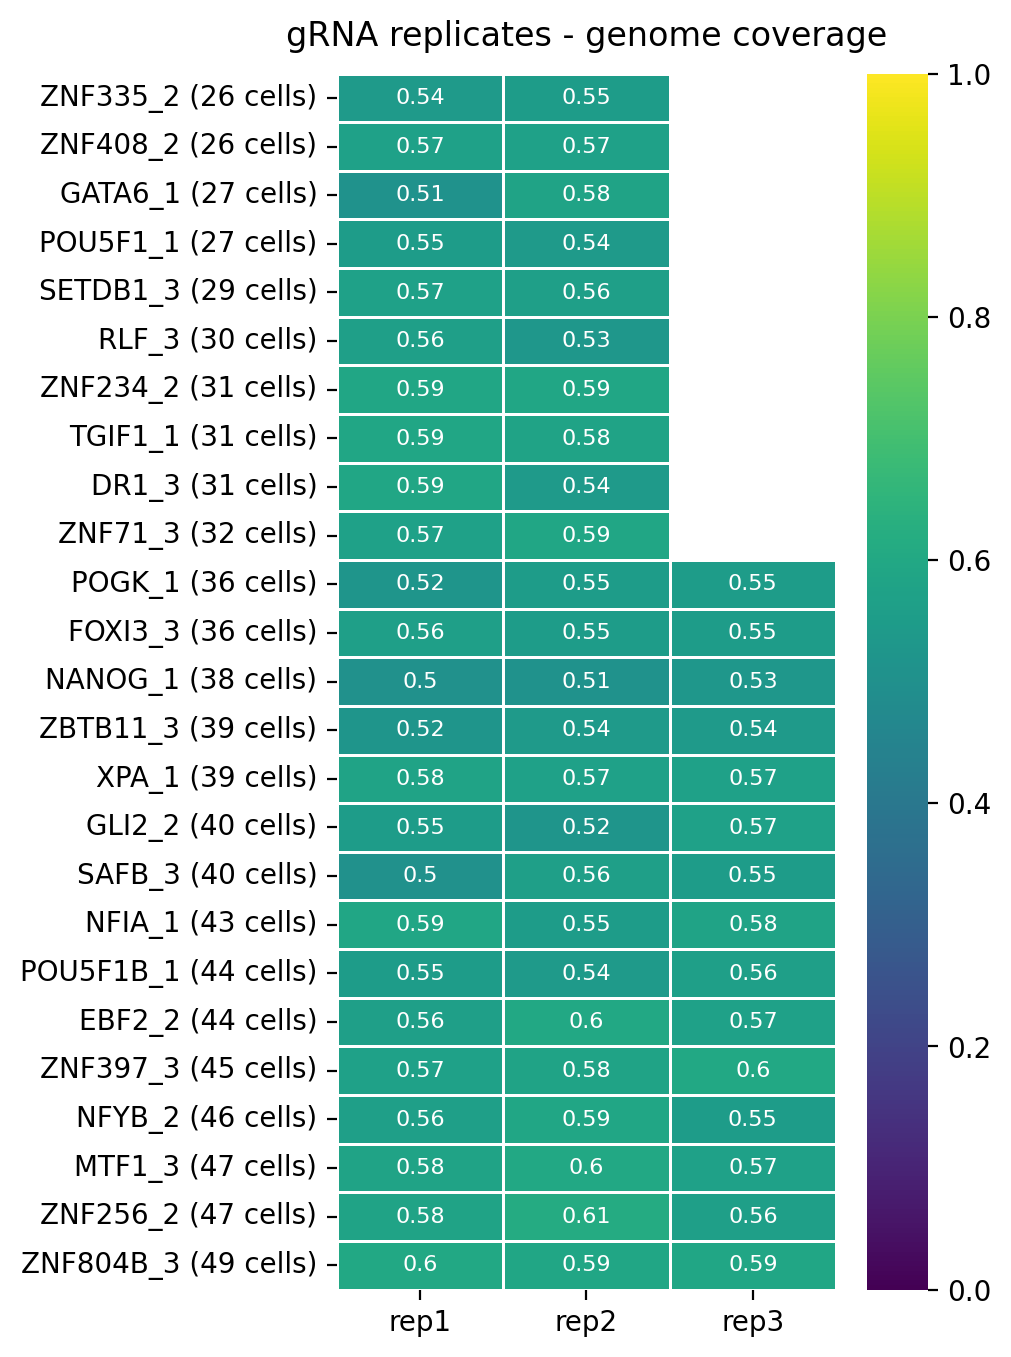

In [18]:
plot_gene_coverage_heatmap(gRNA_genome_coverage_df, figsize=(4,8),
    title="gRNA replicates - genome coverage")

Each pseudoreplicate only has 55-60% genome coverage. Apply stricter gene filter.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'DejaVu Sans'
import seaborn as sns
import scanpy as sc

def filter_low_expressed_genes(adata, percent_threshold=0, min_n_cells=0, silent=False):
    """
    Filter out bottom percentile of genes with lowest expression (counts) 
    and genes expressed in fewer than min_n_cells cells.
    Do not filter out genes that are gene_targets in adata.
    """
    n_genes_before = adata.shape[1]

    # Filter genes expressed in fewer than min_n_cells cells
    if silent == False:
        print(f"Removing non-TF genes expressed in <{min_n_cells} cells")
    # Create data matrix
    if silent == False:
        print("Copying data")
    data_matrix = adata.layers["counts"] if "counts" in adata.layers else adata.X
    data_matrix = data_matrix.copy()
    # Convert from sparse to dense if necessary
    if hasattr(data_matrix, 'toarray'):
        if silent == False:
            print("Converting data from sparse to dense")
        data_matrix = data_matrix.toarray()
    if silent == False:
        print("Filtering genes")
    # Create mask for TFs
    tf_mask = adata.var_names.isin(adata.obs.gene_target.unique().tolist())
    # Calculate number of cells expressing each gene
    gene_detected_counts = (data_matrix > 0).sum(axis=0)
    # Set cell number threshold and filter genes
    genes_pass_cell_thr = gene_detected_counts >= min_n_cells
    genes_to_keep = genes_pass_cell_thr | tf_mask
    adata = adata[:, genes_to_keep]
    print(f"Removed {n_genes_before - adata.n_vars} "
        f"non-TF genes expressed in <{min_n_cells} cells")
    n_genes_after_cell_filt = adata.n_vars
    del data_matrix

    # Filter bottom percentile of genes by expression (counts)
    if silent == False:
        print(f"\nRemoving bottom {percent_threshold}% of genes by expression (CPM)")
    if silent == False:
        print("Copying data")
    adata_norm = adata.copy()
    sc.pp.normalize_total(adata_norm, target_sum=1e6)
    if silent == False:
        print("Copying normalized data")
    data_matrix = adata_norm.X.copy()
    # Convert from sparse to dense if necessary
    if hasattr(data_matrix, 'toarray'):
        if silent == False:
            print("Converting data from sparse to dense")
        data_matrix = data_matrix.toarray()
    if silent == False:
        print("Filtering genes")
    # Create mask for TFs
    tf_mask = adata.var_names.isin(adata.obs.gene_target.unique().tolist())
    # Calculate mean expression of each gene
    mean_expr_per_gene = data_matrix.mean(axis=0)
    # Set percent threshold and filter genes
    threshold = np.percentile(mean_expr_per_gene, percent_threshold)
    genes_pass_pct_thr = mean_expr_per_gene > threshold
    genes_to_keep = genes_pass_pct_thr | tf_mask
    adata = adata[:,genes_to_keep]
    print(f"Removed {n_genes_after_cell_filt - adata.n_vars} non-TF genes "
            f"with lowest {percent_threshold}% expression (CPM)")
    print(f"\nRemoved: {n_genes_before - adata.shape[1]} genes total")
    print(f"Remaining: {adata.n_vars} genes")
    del data_matrix
    del adata_norm
    gc.collect()
    return adata.copy()

In [16]:
adata_filt = filter_low_expressed_genes(adata, min_n_cells=100, percent_threshold=20)

Removing non-TF genes expressed in <100 cells
Copying data
Converting data from sparse to dense
Filtering genes
Removed 188 non-TF genes expressed in <100 cells

Removing bottom 20% of genes by expression (CPM)
Copying data
normalizing counts per cell
    finished (0:00:00)
Copying normalized data
Converting data from sparse to dense
Filtering genes
Removed 3740 non-TF genes with lowest 20% expression (CPM)

Removed: 3928 genes total
Remaining: 16115 genes


In [20]:
gRNA_genome_coverage_df_filt = build_DE_gRNA_rep_genome_coverage_df(adata_filt, 
    n_cells_per_gRNA = [25, 30, 35, 40, 45, 50], n_gRNA_per_size=5, 
    include_total=False, random_state=12345)

Computing genome coverage for gRNA: 100%|██████████| 25/25 [00:42<00:00,  1.72s/it]


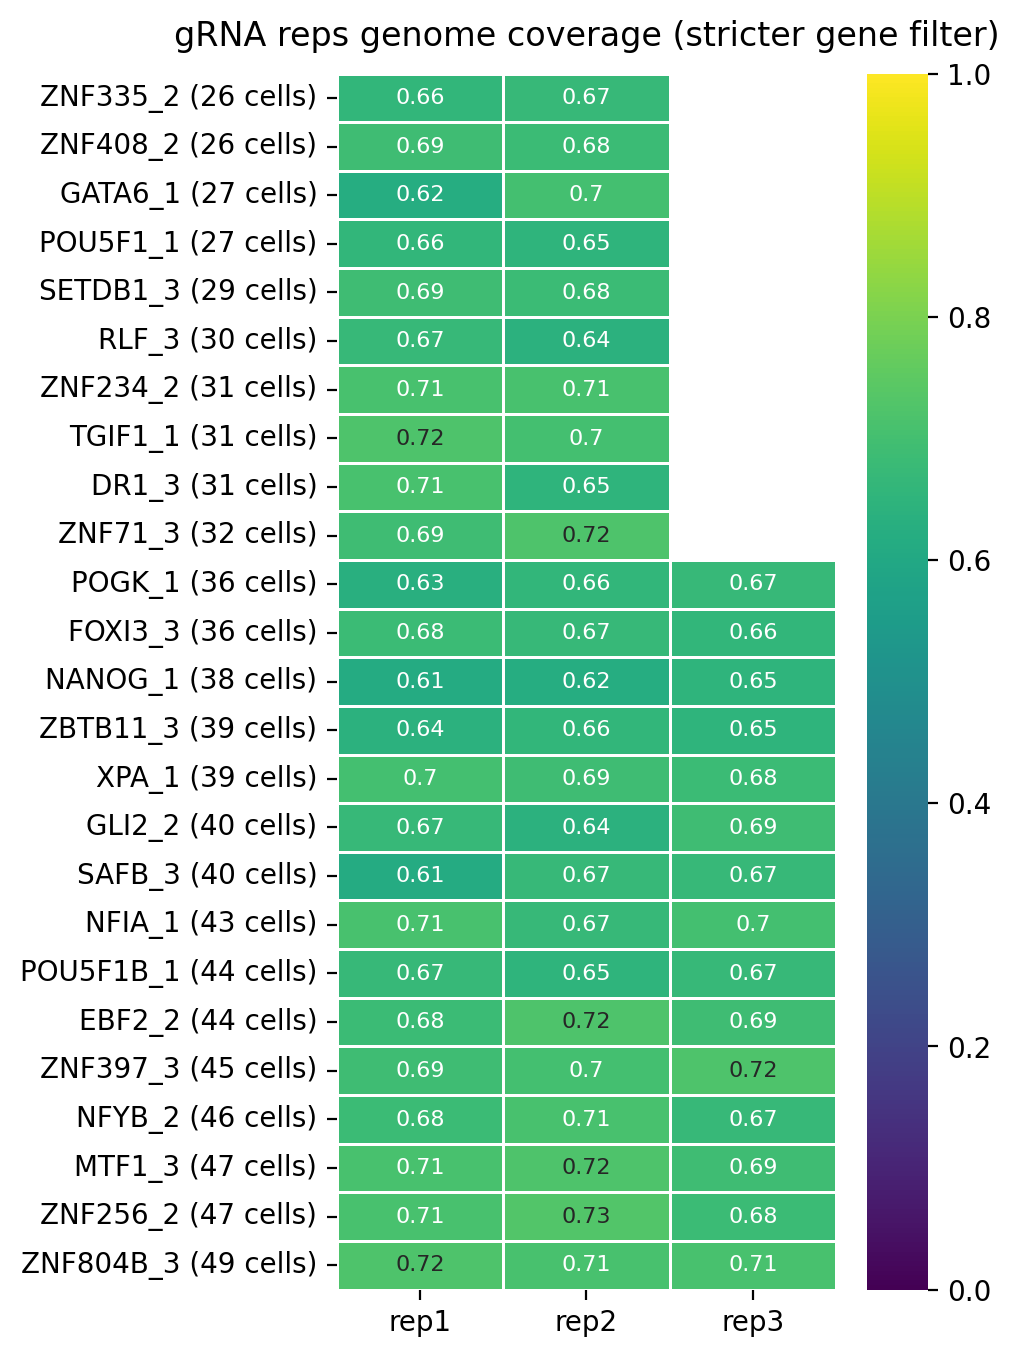

In [21]:
plot_gene_coverage_heatmap(gRNA_genome_coverage_df_filt, figsize=(4,8),
    title="gRNA reps genome coverage (stricter gene filter)")

Each pseudoreplicate now has ~65-75% genome coverage. This gene filter is adequate and now DE analysis can be performed.

In [ ]:
adata_filt.write("/home/ranwyl/data_tf_project/KOLF_Pan_Genome_Alpha_CPMnorm_KD_ETest_Gene_Filtered.h5ad")

### DE on gRNA

In [ ]:
import anndata as ad
import numpy as np
import pandas as pd
from scipy import sparse
from tqdm_joblib import tqdm_joblib
from joblib import Parallel, delayed
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from pydeseq2.default_inference import DefaultInference
import warnings
from contextlib import contextmanager
import gc

def create_pseudobulk_dataset(adata: ad.AnnData, target_type: str = "gRNA",
                              ntc_benchmarking: bool = False,
                              layer: str = "counts",
                              min_cells_for_3_reps: int = 60,
                              approx_ntc_rep_size: int = 50,
                              random_state: int = 42,
                              ntc_target_delimiter: str = "NTC",
                              ntc_gRNA_delimiter: str = "Non-Targeting"):
    """
    Generate pseudobulk representation of adata with pseudoreplicates for 
    each gRNA or gene target (based on target_type).
    """
    # Error handling
    if (target_type != "gRNA") & (target_type != "gene_target"):
        raise ValueError("Error: target_type must be 'gRNA' or 'gene_target'")
    if (ntc_benchmarking is True) & (target_type != "gRNA"):
        raise ValueError("Error: target_type must be 'gRNA' for NTC benchmarking")

    # Get targets
    targets = adata.obs[target_type].unique().tolist()
    # RNG objects for creating pseudoreplicates
    de_rng = np.random.default_rng(random_state)
    target_rngs = de_rng.spawn(len(targets))

    # Data structures for counts_df and metadata_df
    counts_arrays, counts_df_index = list(), list()
    metadata_condition, metadata_n_cells = list(), list()

    # Get data and convert from sparse to dense
    data_matrix = adata.layers[layer] if layer in adata.layers else adata.X
    if sparse.issparse(data_matrix):
        data_matrix = data_matrix.toarray()

    # Generate pseudoreplicates
    for target, rng in zip(targets, target_rngs):
        # Get target data
        target_indices = np.where(adata.obs[target_type] == target)[0]
        target_data = data_matrix[target_indices]
        
        # Calculate pseudoreplicate size
        n_target_cells = target_data.shape[0]
        if target_type == "gRNA": # gRNA targets
            if n_target_cells < min_cells_for_3_reps:
                rep1_size = n_target_cells // 2
                rep2_size = n_target_cells - rep1_size
                rep_sizes = [rep1_size, rep2_size]
            else:
                rep1_size = n_target_cells // 3
                rep2_size = (n_target_cells - rep1_size) // 2
                rep3_size = n_target_cells - rep1_size - rep2_size
                rep_sizes = [rep1_size, rep2_size, rep3_size]
        else: # Gene targets
            # Create NTC reps of about approx_ntc_rep_size as evenly as possible
            if target == ntc_target_delimiter:
                n_reps = round(n_target_cells / approx_ntc_rep_size)
                base_size = n_target_cells // n_reps
                remainder = n_target_cells % n_reps
                # First 'remainder' reps get one extra item
                rep_sizes = \
                    [base_size+1]*remainder + [base_size]*(n_reps-remainder)
            else:
                if n_target_cells < min_cells_for_3_reps:
                    rep1_size = n_target_cells // 2
                    rep2_size = n_target_cells - rep1_size
                    rep_sizes = [rep1_size, rep2_size]
                else:
                    rep1_size = n_target_cells // 3
                    rep2_size = (n_target_cells - rep1_size) // 2
                    rep3_size = n_target_cells - rep1_size - rep2_size
                    rep_sizes = [rep1_size, rep2_size, rep3_size]

        # Sample target indices for each rep
        target_cell_indices = np.arange(n_target_cells)
        rng.shuffle(target_cell_indices)
        rep_sizes_array = np.array(rep_sizes)
        rep_splits = np.cumsum(rep_sizes_array)[:-1]
        rep_indices = np.split(target_cell_indices, rep_splits)
        
        # Update pseudobulk counts
        n_reps = len(rep_sizes)
        target_counts = np.zeros((n_reps, target_data.shape[1]), dtype=np.int64)
        for i in range(n_reps):
            target_counts[i] = \
                np.sum(target_data[rep_indices[i]], axis=0).astype(np.int64)
        counts_arrays.append(target_counts)
        target_hyphenated = target.replace("_", "-")
        rep_names = [f"{target_hyphenated}-rep{i+1}" for i in range(n_reps)]
        counts_df_index += rep_names
        
        # Update metadata
        metadata_n_cells += rep_sizes
        if ntc_gRNA_delimiter in target:
            metadata_condition += (["NTC"]*n_reps)
        else:
            metadata_condition += ([target_hyphenated]*n_reps)
            
            
    # Create counts DF
    counts_arr = np.concatenate(tuple(arr for arr in counts_arrays), axis=0)
    counts_df = pd.DataFrame(
        counts_arr,
        index=counts_df_index,
        columns=adata.var_names
    )
    # Create metadata DF
    metadata_dict = {"sample": counts_df_index,
                    "condition": metadata_condition,
                    "n-cells-in-rep": metadata_n_cells}
    metadata_df = pd.DataFrame.from_dict(metadata_dict)
    metadata_df = metadata_df.set_index("sample").rename_axis(None)
    return counts_df, metadata_df

# Handle warnings (from PyDESeq2)
@contextmanager
def handle_warnings(suppress):
    if suppress:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            yield
    else:
        yield

def run_pydeseq2(counts_df: pd.DataFrame, metadata_df: pd.DataFrame,
                 n_cpus: int = 20, alpha: float = 0.05,
                 shrink_lfcs: bool = False, lfc_shrink_adapt: bool = True,
                 suppress_warnings: bool = False):
    """
    Perform DE analysis with PyDESeq2 on perturbing gRNA or gene targets.
    Uses parallel processing for DeseqStats.summary().
    """
    with handle_warnings(suppress_warnings):
        # Set number of CPUs to use
        dds_inference = DefaultInference(n_cpus=n_cpus)
        ds_inference = DefaultInference(n_cpus=1)
        # Fit dispersions and LFCs
        dds = DeseqDataSet(counts=counts_df, metadata=metadata_df,
                          design_factors="condition",
                          continuous_factors=["n-cells-in-rep"],
                          ref_level=["condition", "NTC"],
                          inference=dds_inference, quiet=True
                          )
        dds.deseq2()
        # Helper function for statistical testing
        def run_DeseqStats(target, shrink_lfcs, lfc_shrink_adapt):
            contrast=["condition", target, "NTC"]
            ds = DeseqStats(dds, contrast=contrast, alpha=alpha,
                            inference=ds_inference, quiet=True)
            ds.summary()
            if shrink_lfcs:
                coeff = f"{contrast[0]}_{contrast[1]}_vs_{contrast[2]}"
                ds.lfc_shrink(coeff=coeff, adapt=lfc_shrink_adapt)
            return ds.results_df
        # Perform statistical testing in parallel
        targets_hyphenated = metadata_df["condition"].unique().tolist()
        if "NTC" in targets_hyphenated:
            targets_hyphenated.remove("NTC")
        with tqdm_joblib(desc="Running DE analysis", total=len(targets_hyphenated)):
            ds_results = Parallel(n_jobs=n_cpus)(
                delayed(run_DeseqStats)(target, shrink_lfcs, lfc_shrink_adapt)
                        for target in targets_hyphenated)
        # Return results
        targets = [target.replace("-", "_") for target in targets_hyphenated]
        de_results_dict = {targets[i]: ds_results[i] for i in range(len(targets))}
        return de_results_dict


def run_dataset_DE(adata: ad.AnnData, target_type: str = "gRNA",
                layer: str = "counts",
                min_cells_for_3_reps: int = 60,
                approx_ntc_rep_size: int = 50,
                random_state: int = 42,
                ntc_target_delimiter: str = "NTC",
                ntc_gRNA_delimiter: str = "Non-Targeting",
                n_cpus: int = 20, alpha: float = 0.05,
                shrink_lfcs: bool = False, lfc_shrink_adapt: bool = True,
                suppress_warnings: bool = False):
    """
    Run pseudobulk DE on perturbing gRNA or gene targets (based on target_type).
    """
    # Create pseudobulk dataset
    counts_df, metadata_df = \
        create_pseudobulk_dataset(adata, target_type=target_type, layer=layer,
                                    min_cells_for_3_reps=min_cells_for_3_reps,
                                    approx_ntc_rep_size = approx_ntc_rep_size,
                                    random_state=random_state,
                                    ntc_target_delimiter=ntc_target_delimiter,
                                    ntc_gRNA_delimiter=ntc_gRNA_delimiter)
    # Run DE analysis on pseudobulk dataset
    de_results_dict = run_pydeseq2(counts_df, metadata_df,
                    n_cpus=n_cpus, alpha=alpha,
                    shrink_lfcs=shrink_lfcs, 
                    lfc_shrink_adapt=lfc_shrink_adapt,
                    suppress_warnings=suppress_warnings)
    return de_results_dict

In [ ]:
# NTC benchmarking
def ntc_benchmarking_DE(adata: ad.AnnData,
                        layer: str = "counts",
                        min_cells_for_3_reps: int = 60,
                        random_state: int = 42,
                        ntc_target_delimiter: str = "NTC",
                        ntc_gRNA_delimiter: str = "Non-Targeting",
                        n_cpus: int = 20, alpha: float = 0.05,
                        suppress_warnings: bool = False):
    """
    Perform DE analysis on all NTC gRNA against all other NTC cells.
    Return dict {NTC gRNA: DE results DF for that NTC gRNA}.
    """
    adata = adata[adata.obs.gene_target == ntc_target_delimiter]
    # Create pseudobulk representation of dataset
    counts_df, metadata_df = \
        create_pseudobulk_dataset(adata, target_type="gRNA", 
                                  ntc_benchmarking=True, layer=layer,
                                  min_cells_for_3_reps=min_cells_for_3_reps,
                                  random_state=random_state,
                                  ntc_target_delimiter=ntc_target_delimiter,
                                  ntc_gRNA_delimiter=ntc_gRNA_delimiter)

    # Helper function to run DE on single NTC gRNA
    def ntc_benchmarking_single_gRNA(counts_df, metadata_df, target_ntc_gRNA):
        # Temporarily change 'condition' to 'perturbed'
        metadata_df = metadata_df.copy()
        metadata_df.loc[
            metadata_df.index.str.contains(target_ntc_gRNA), "condition"] = "perturbed"
        # Run DESeq2
        with handle_warnings(suppress_warnings):
            dds_inference = DefaultInference(n_cpus=1)
            ds_inference = DefaultInference(n_cpus=1)
            dds = DeseqDataSet(counts=counts_df, 
                               metadata=metadata_df,
                               design_factors="condition",
                               continuous_factors=["n-cells-in-rep"],
                               ref_level=["condition", "NTC"],
                               inference=dds_inference, 
                               quiet=True)
            dds.deseq2()
            ds = DeseqStats(dds, 
                            contrast=["condition", "perturbed", "NTC"], 
                            alpha=alpha,
                            inference=ds_inference, 
                            quiet=True)
            ds.summary()
            return ds.results_df
    
    # Run DE on all NTC gRNA
    targets = adata.obs.gRNA.unique().tolist()
    targets_hyphenated = [target.replace("_", "-") for target in targets]
    with tqdm_joblib(desc="Running DE analysis", total=len(targets)):
        de_results = Parallel(n_jobs=n_cpus)(
            delayed(ntc_benchmarking_single_gRNA)(counts_df, metadata_df, target)
                    for target in targets_hyphenated)
    de_results_dict = {targets[i]: de_results[i] for i in range(len(targets))}
    return de_results_dict

def report_ntc_benchmarking_results(results_dict: dict, alpha: float = 0.05):
        """
        Determine the threshold (number of DEGs) at which 95% of NTC gRNA have 
        fewer DEGs. Plot the distribution of DEGs for NTC gRNA and print
        a summary of results.
        """
        # Counts DEGs per gRNA
        deg_counts = {}
        for ntc_gRNA, result_df in results_dict.items():
            if result_df is None:
                continue
            deg_count = sum((result_df['padj'] < alpha) & pd.notna(result_df['padj']))
            deg_counts[ntc_gRNA] = deg_count

        # Create results DataFrame
        benchmark_results = pd.DataFrame.from_dict(deg_counts, orient='index', columns=['n_DEGs'])
        benchmark_results = benchmark_results.sort_values('n_DEGs', ascending=False)
        
        # Calculate 95th percentile threshold (FDR 0.05)
        if len(benchmark_results) > 0:
            deg_threshold = np.percentile(benchmark_results['n_DEGs'].values, 95)
        else:
            print("No results to calculate percentile.")
            return
        
        # Plot results with improved styling - code from psp.de.benchmark_NTC_FDR()
        # Set style parameters
        plt.rcParams['axes.spines.top'] = False
        plt.rcParams['axes.spines.right'] = False
        # Create figure
        fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
        fig.patch.set_facecolor('white')
        # Prepare bar plot data: discrete DEG counts
        deg_counts = benchmark_results['n_DEGs'].value_counts().sort_index()
        # Create bar plot
        ax.bar(
            deg_counts.index,
            deg_counts.values,
            alpha=0.8,
            color='#4682B4',   # Steel blue
            edgecolor='white',
            linewidth=1.5
        )
        # Add threshold line with improved styling
        ax.axvline(
            deg_threshold,
            color='#B22222',  # Firebrick
            linestyle='-',
            linewidth=2,
            alpha=0.8
        )
        # Labels and title with improved styling
        ax.set_xlabel('Number of DEGs', fontsize=12, labelpad=10)
        ax.set_ylabel('Number of NTC sgRNA comparisons', fontsize=12, labelpad=10)
        ax.set_title(f'Distribution of DEGs in NTC comparisons', fontsize=14, pad=20)
        # Turn off grid
        ax.grid(False)
        # Adjust tick parameters
        ax.tick_params(axis='both', which='major', labelsize=10, pad=5)
        # Add some padding to the axes
        ax.margins(x=0.02)
        # Add custom legend-like text at bottom
        threshold_text = f"FDR 0.05 threshold: {int(deg_threshold)} DEGs"
        fig.text(0.5, 0.01, threshold_text, ha='center', fontsize=11, color='#B22222', weight='bold')
        # Adjust layout
        plt.tight_layout(rect=[0, 0.02, 1, 0.98])
        plt.show()
        
        # Print statistics
        print(f"NTC Benchmark Statistics:")
        print(f"  • FDR 0.05 threshold: {int(deg_threshold)} DEGs")
        print(f"  • NTC comparisons analyzed: {len(benchmark_results)}")
        print(f"  • Mean DEGs per comparison: {benchmark_results['n_DEGs'].mean():.1f}")
        print(f"  • Median DEGs per comparison: {benchmark_results['n_DEGs'].median():.1f}")
        print(f"  • 95% of comparisons have < {int(deg_threshold)} DEGs")

        return int(deg_threshold), benchmark_results

In [ ]:
data_path = "/home/ranwyl/data_tf_project/KOLF_Pan_Genome_Alpha_CPMnorm_KD_ETest_Gene_Filtered.h5ad"
adata = psp.utils.read_anndata(data_path)
adata

AnnData object with n_obs × n_vars = 101923 × 20043
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'perturbation', 'gene_target_ensembl_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'perturbation_edist', 'perturbation_pvalue', 'perturbation_significant'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'etest_results', 'etest_results_params'
    layers: 'counts'

Apply stricter gene filter

In [5]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'DejaVu Sans'
import seaborn as sns
import scanpy as sc

def filter_low_expressed_genes(adata, percent_threshold=0, min_n_cells=0, silent=False):
    """
    Filter out bottom percentile of genes with lowest expression (counts) 
    and genes expressed in fewer than min_n_cells cells.
    Do not filter out genes that are gene_targets in adata.
    """
    n_genes_before = adata.shape[1]

    # Filter genes expressed in fewer than min_n_cells cells
    if silent == False:
        print(f"Removing non-TF genes expressed in <{min_n_cells} cells")
    # Create data matrix
    if silent == False:
        print("Copying data")
    data_matrix = adata.layers["counts"] if "counts" in adata.layers else adata.X
    data_matrix = data_matrix.copy()
    # Convert from sparse to dense if necessary
    if hasattr(data_matrix, 'toarray'):
        if silent == False:
            print("Converting data from sparse to dense")
        data_matrix = data_matrix.toarray()
    if silent == False:
        print("Filtering genes")
    # Create mask for TFs
    tf_mask = adata.var_names.isin(adata.obs.gene_target.unique().tolist())
    # Calculate number of cells expressing each gene
    gene_detected_counts = (data_matrix > 0).sum(axis=0)
    # Set cell number threshold and filter genes
    genes_pass_cell_thr = gene_detected_counts >= min_n_cells
    genes_to_keep = genes_pass_cell_thr | tf_mask
    adata = adata[:, genes_to_keep]
    print(f"Removed {n_genes_before - adata.n_vars} "
        f"non-TF genes expressed in <{min_n_cells} cells")
    n_genes_after_cell_filt = adata.n_vars
    del data_matrix

    # Filter bottom percentile of genes by expression (counts)
    if silent == False:
        print(f"\nRemoving bottom {percent_threshold}% of genes by expression (CPM)")
    if silent == False:
        print("Copying data")
    adata_norm = adata.copy()
    sc.pp.normalize_total(adata_norm, target_sum=1e6)
    if silent == False:
        print("Copying normalized data")
    data_matrix = adata_norm.X.copy()
    # Convert from sparse to dense if necessary
    if hasattr(data_matrix, 'toarray'):
        if silent == False:
            print("Converting data from sparse to dense")
        data_matrix = data_matrix.toarray()
    if silent == False:
        print("Filtering genes")
    # Create mask for TFs
    tf_mask = adata.var_names.isin(adata.obs.gene_target.unique().tolist())
    # Calculate mean expression of each gene
    mean_expr_per_gene = data_matrix.mean(axis=0)
    # Set percent threshold and filter genes
    threshold = np.percentile(mean_expr_per_gene, percent_threshold)
    genes_pass_pct_thr = mean_expr_per_gene > threshold
    genes_to_keep = genes_pass_pct_thr | tf_mask
    adata = adata[:,genes_to_keep]
    print(f"Removed {n_genes_after_cell_filt - adata.n_vars} non-TF genes "
            f"with lowest {percent_threshold}% expression (CPM)")
    print(f"\nRemoved: {n_genes_before - adata.shape[1]} genes total")
    print(f"Remaining: {adata.n_vars} genes")
    del data_matrix
    del adata_norm
    gc.collect()
    return adata.copy()

In [6]:
adata = filter_low_expressed_genes(adata, min_n_cells=100, percent_threshold=20)

Removing non-TF genes expressed in <100 cells
Copying data
Converting data from sparse to dense
Filtering genes
Removed 188 non-TF genes expressed in <100 cells

Removing bottom 20% of genes by expression (CPM)
Copying data
normalizing counts per cell
    finished (0:00:00)
Copying normalized data
Converting data from sparse to dense
Filtering genes
Removed 3740 non-TF genes with lowest 20% expression (CPM)

Removed: 3928 genes total
Remaining: 16115 genes


In [7]:
adata

AnnData object with n_obs × n_vars = 101923 × 16115
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'perturbation', 'gene_target_ensembl_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'perturbation_edist', 'perturbation_pvalue', 'perturbation_significant'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'etest_results', 'etest_results_params'
    layers: 'counts'

Test

In [8]:
test_adata = adata[(adata.obs.perturbed == "False") |
                   (adata.obs.gene_target.isin(test_kds))].copy()
test_adata

AnnData object with n_obs × n_vars = 14437 × 16115
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'perturbation', 'gene_target_ensembl_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'perturbation_edist', 'perturbation_pvalue', 'perturbation_significant'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'etest_results', 'etest_results_params'
    layers: 'counts'

In [9]:
test_adata.obs.perturbed.value_counts()

perturbed
False    13674
True       763
Name: count, dtype: int64

In [ ]:
print(f"test_adata gene targets: {', '.join(test_adata.obs.gene_target.unique().tolist())}")

test_adata gene targets: NTC, PHF20, DNMT1, POU5F1, NANOG, ZNF396, POU5F1B, POU3F2, ZNF521


In [12]:
test_de_results12 = differential_expression(test_adata, min_cells_per_rep=12)

Running DE analysis:   0%|          | 0/14 [00:00<?, ?it/s]

/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:497: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:497: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()


In [13]:
test_de_results15 = differential_expression(test_adata, min_cells_per_rep=15)

Running DE analysis:   0%|          | 0/14 [00:00<?, ?it/s]

/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:497: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:497: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:497: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:497: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is es

In [14]:
test_adata_pipeline = test_adata.copy()
pipeline_de_results = psp.de.differential_expression(test_adata_pipeline, plot_degs=False)

Processing perturbations:   0%|          | 0/14 [00:00<?, ?it/s]


Updating adata object with DEG counts
2025-10-24 15:13:14 - INFO - Completed differential expression analysis in 135.26 seconds


In [15]:
def build_DE_test_results_df(tf_de_results: dict, pipeline_de_results: dict, 
                             adata: ad.AnnData, tf_min_cells_per_rep: int,
                             pipeline_sample_fraction: float=0.7, 
                             alpha: float=0.05, target_column: str = "gRNA"):
    
    target_list = sorted(list(tf_de_results.keys()))
    n_cells_list = [adata[adata.obs[target_column] == target].shape[0] for target in target_list]
    tf_reps_cells_list, tf_n_degs_list = list(), list()
    pipeline_reps_cells_list, pipeline_n_degs_list = list(), list()

    for i in range(len(target_list)):
        target = target_list[i]
        # TF project n_reps x n_cells
        n_cells = n_cells_list[i]
        if n_cells < 2 * tf_min_cells_per_rep:
            res = f"2 x {n_cells // 2} cells"
        else:
            n_reps = min(3, n_cells // tf_min_cells_per_rep)
            n_cells_per_rep = n_cells // n_reps
            res = f"{n_reps} x {n_cells_per_rep} cells"
        tf_reps_cells_list.append(res)
        # Pipeline n_reps x n_cells
        res = f"3 x {int(n_cells * pipeline_sample_fraction)} cells"
        pipeline_reps_cells_list.append(res)
        # TF project number of DEGs
        de_df = tf_de_results[target]
        degs = set(de_df[de_df["padj"] < alpha].index.tolist())
        tf_n_degs_list.append(len(degs))
        # Pipeline number of DEGs
        de_df = pipeline_de_results[target]
        degs = set(de_df[de_df["padj"] < alpha].index.tolist())
        pipeline_n_degs_list.append(len(degs))
    
    results_dict = {target_column: target_list, 
                    "# cells": n_cells_list, 
                    "TF # DEGs": tf_n_degs_list,
                    "Pipeline # DEGs": pipeline_n_degs_list,
                    "TF reps x cells": tf_reps_cells_list,
                    "Pipeline reps x cells": pipeline_reps_cells_list}         
    results_df = pd.DataFrame.from_dict(results_dict)
    return results_df

In [16]:
de_test_results_df12 = \
    build_DE_test_results_df(test_de_results12, pipeline_de_results, test_adata, 
                             tf_min_cells_per_rep=12,
                             pipeline_sample_fraction=0.7,
                             alpha=0.05)

In [17]:
display(de_test_results_df12.sort_values(by="# cells"))

,gRNA,# cells,TF # DEGs,Pipeline # DEGs,TF reps x cells,Pipeline reps x cells
8,POU5F1_1,27,40,489,2 x 13 cells,3 x 18 cells
9,POU5F1_2,29,33,533,2 x 14 cells,3 x 20 cells
3,NANOG_1,38,3,60,3 x 12 cells,3 x 26 cells
7,POU5F1B_1,44,100,656,3 x 14 cells,3 x 30 cells
1,DNMT1_2,45,14,80,3 x 15 cells,3 x 31 cells
5,PHF20_1,46,95,412,3 x 15 cells,3 x 32 cells
6,POU3F2_2,50,62,403,3 x 16 cells,3 x 35 cells
0,DNMT1_1,50,5,71,3 x 16 cells,3 x 35 cells
10,POU5F1_3,50,94,550,3 x 16 cells,3 x 35 cells
12,ZNF396_2,51,38,188,3 x 17 cells,3 x 35 cells


In [18]:
de_test_results_df15 = \
    build_DE_test_results_df(test_de_results15, pipeline_de_results, test_adata, 
                             tf_min_cells_per_rep=15,
                             pipeline_sample_fraction=0.7,
                             alpha=0.05)

In [19]:
display(de_test_results_df15.sort_values(by="# cells"))

,gRNA,# cells,TF # DEGs,Pipeline # DEGs,TF reps x cells,Pipeline reps x cells
8,POU5F1_1,27,40,489,2 x 13 cells,3 x 18 cells
9,POU5F1_2,29,33,533,2 x 14 cells,3 x 20 cells
3,NANOG_1,38,1,60,2 x 19 cells,3 x 26 cells
7,POU5F1B_1,44,58,656,2 x 22 cells,3 x 30 cells
1,DNMT1_2,45,14,80,3 x 15 cells,3 x 31 cells
5,PHF20_1,46,95,412,3 x 15 cells,3 x 32 cells
6,POU3F2_2,50,62,403,3 x 16 cells,3 x 35 cells
0,DNMT1_1,50,5,71,3 x 16 cells,3 x 35 cells
10,POU5F1_3,50,94,550,3 x 16 cells,3 x 35 cells
12,ZNF396_2,51,38,188,3 x 17 cells,3 x 35 cells


In [20]:
test_de_results_gene_target = differential_expression(test_adata, 
                                                      target_column="gene_target",
                                                      min_cells_per_rep=12)

Running DE analysis:   0%|          | 0/8 [00:00<?, ?it/s]

In [21]:
test_adata_pipeline = test_adata.copy()
pipeline_de_results_gene_target = \
    psp.de.differential_expression(test_adata_pipeline, 
                                   adata_deg_test_column="gene_target",
                                   plot_degs=False)

Processing perturbations:   0%|          | 0/8 [00:00<?, ?it/s]


Updating adata object with DEG counts
2025-10-24 15:23:00 - INFO - Completed differential expression analysis in 80.11 seconds


In [22]:
de_test_results_gene_target_df = \
    build_DE_test_results_df(test_de_results_gene_target, 
                             pipeline_de_results_gene_target, 
                             test_adata, 
                             tf_min_cells_per_rep=12,
                             pipeline_sample_fraction=0.7,
                             alpha=0.05,
                             target_column="gene_target")

In [23]:
display(de_test_results_gene_target_df.sort_values(by="# cells"))

,gene_target,# cells,TF # DEGs,Pipeline # DEGs,TF reps x cells,Pipeline reps x cells
5,POU5F1B,44,122,585,3 x 14 cells,3 x 30 cells
2,PHF20,46,95,544,3 x 15 cells,3 x 32 cells
3,POU3F2,50,57,443,3 x 16 cells,3 x 35 cells
7,ZNF521,83,62,317,3 x 27 cells,3 x 58 cells
4,POU5F1,106,436,1565,3 x 35 cells,3 x 74 cells
1,NANOG,119,61,265,3 x 39 cells,3 x 83 cells
0,DNMT1,147,70,338,3 x 49 cells,3 x 102 cells
6,ZNF396,168,11,132,3 x 56 cells,3 x 117 cells


### Test - NTC benchmarking

In [27]:
def benchmark_NTC_FDR(
    adata: ad.AnnData,
    gRNA_column: str = "gRNA",
    ntc_cells_delimiter: str = "Non-Targeting",
    layer: str = "counts",
    min_cells_per_rep: int = 12,
    alpha: float = 0.05,
    n_cpus: int = 16,
    random_state: int = 42,
    debug: bool = False
):
    """
    Benchmark FDR control by comparing NTC sgRNAs against each other.
    For each NTC sgRNA, run DE analysis against all other NTC sgRNAs.
    Calculate distribution of DEGs (FDR < 0.05) per NTC sgRNA. 
    Determine threshold at which 95% of NTC sgRNAs have fewer DEGs.
    Add a column to adata.obs indicating if each perturbation exceeds
    the NTC FDR threshold. Not batch-aware. No results stored in adata.

    gRNA_column: adata.obs column with identifier for each sgRNA, default "gRNA"
    ntc_cells_delimiter: prefix of NTC sgRNA in gRNA column, default "Non-Targeting"
    layer: AnnData object layer to use for DE analysis, default "counts"
    alpha: significance threshold for DESeq2, default 0.05
    """
    # Get AnnData with only NTC cells based on gRNA_column and delimiter
    ntc_mask = adata.obs[gRNA_column].astype(str).str.contains(ntc_cells_delimiter)
    if not ntc_mask.any():
        raise ValueError(f"No NTC cells found in {gRNA_column} containing "
                         f"'{ntc_cells_delimiter}'")
    ntc_adata = adata[ntc_mask].copy()

    # Get unique NTC sgRNAs
    if gRNA_column not in ntc_adata.obs.columns:
        raise ValueError(f"Column '{gRNA_column}' not found in adata.obs")
    ntc_sgRNAs = list(ntc_adata.obs[gRNA_column].unique())
    if len(ntc_sgRNAs) < 3:
        print(f"Not enough unique NTC sgRNAs for benchmarking (need at least 3, found {len(ntc_sgRNAs)})")
        return
    if debug == True:
        print("Running in debug mode with 5 NTC sgRNA")
        ntc_sgRNAs = ntc_sgRNAs[:5]

    # Create RNG object to handle case where one is not provided
    de_rng = np.random.default_rng(random_state)
    # Create one child RNG object per NTC sgRNA
    streams = de_rng.spawn(len(ntc_sgRNAs))

    # Determine how many CPUs to use per joblib Parallel job
    #   and per DE analysis run
    if n_cpus < 3:
        n_cpus_for_DE = n_cpus
    elif n_cpus <= 10:
        n_cpus_for_DE = 3
    elif 20 <= n_cpus < 30:
        n_cpus_for_DE = 4
    elif 30 <= n_cpus < 50:
        n_cpus_for_DE = 5
    else:
        n_cpus_for_DE = 6
    n_jobs = max(1, n_cpus // n_cpus_for_DE)
    
    # Warning if given layer not found
    if layer not in adata.layers:
        print(f"Warning: {layer} not found in adata.layers, using adata.X instead")

    # Helper function
    def process_ntc_gRNA(target_ntc_gRNA: str,
                         rng: np.random.Generator):
        # Check if there are enough target cells
        target_cells = ntc_adata[ntc_adata.obs[gRNA_column] == target_ntc_gRNA].obs.index
        if len(target_cells) < 10:
            print(f"Skipping {target_ntc_gRNA}: too few cells ({len(target_cells)})")
            return
        
        # Get other NTC cells (excluding the target gRNA)
        other_ntc_cells = ntc_adata[ntc_adata.obs[gRNA_column] != target_ntc_gRNA].obs.index
        if len(other_ntc_cells) < 10:
            print(f"Skipping {target_ntc_gRNA}: too few other NTC cells ({len(other_ntc_cells)})")
            return
        
        # Temporarily create "perturbation" column to use with generate_pseudoreplicates_for_DE
        # This labels target gRNA cells as the "perturbation" and other NTC cells as "NTC"
        ntc_adata_temp = ntc_adata.copy()
        ntc_adata_temp.obs["temp_pert"] = "NTC"
        ntc_adata_temp.obs.loc[ntc_adata_temp.obs[gRNA_column] == target_ntc_gRNA, 'temp_pert'] = target_ntc_gRNA
        
        # Generate pseudoreplicates
        pseudo_bulk_df, metadata_df = generate_pseudoreplicates_for_DE(
            ntc_adata_temp, target_ntc_gRNA, other_ntc_cells, rng, 
            target_column="temp_pert", layer=layer, 
            min_cells_per_rep=min_cells_per_rep
        )

        # Set number of CPUs to use for each DE run
        inference = DefaultInference(n_cpus=n_cpus_for_DE) 

        # Read counts modeling and fitting dispersions
        dds = DeseqDataSet(
            counts = pseudo_bulk_df, 
            metadata = metadata_df,
            refit_cooks=True,
            inference=inference,
            quiet=True
            )
        dds.deseq2()
        
        # Statistical testing
        target_hyphenated = target_ntc_gRNA.replace('_', '-')
        contrast = ["condition", target_hyphenated, "NTC"]
        stat_res = DeseqStats(
            dds, 
            contrast=contrast, 
            alpha=alpha,
            inference=inference,
            quiet=True)
        stat_res.summary()
        de_results = stat_res.results_df

        # Clean up memory
        del pseudo_bulk_df, metadata_df, dds, stat_res, ntc_adata_temp
        gc.collect()

        return de_results

    # Run DE analysis on all NTC sgRNA in parallel
    with tqdm_joblib(desc="Running DE analysis", total=len(ntc_sgRNAs)):
        de_results = Parallel(n_jobs=n_jobs)(
            delayed(process_ntc_gRNA)(target_value, rng) 
            for target_value, rng in zip(ntc_sgRNAs, streams))
    results_dict = dict(zip(ntc_sgRNAs, de_results))

    # Check for successful comparisons
    if not results_dict:
        print("No successful comparisons. Check if the data layer contains integer counts.")
        return
    
    # Calculate DEGs per sgRNA-batch (handles sgRNA names with underscores)
    deg_counts = {}
    for key, result_df in results_dict.items():
        if result_df is None:
            continue
        count_key = key
        # Count DEGs for this comparison
        deg_count = sum((result_df['padj'] < alpha) & pd.notna(result_df['padj']))
        deg_counts[count_key] = deg_count

    # Check if we have any DEG counts
    if not deg_counts:
        print("No DEGs found in any comparison.")
        return

    # Create results DataFrame
    benchmark_results = pd.DataFrame.from_dict(deg_counts, orient='index', columns=['n_DEGs'])
    benchmark_results['sgRNA'] = benchmark_results.index

    benchmark_results.index.name = 'key'
    benchmark_results = benchmark_results.sort_values('n_DEGs', ascending=False)
    
    # Calculate 95th percentile threshold (FDR 0.05)
    if len(benchmark_results) > 0:
        deg_threshold = np.percentile(benchmark_results['n_DEGs'].values, 95)
    else:
        print("No results to calculate percentile.")
        return
    
    # Print statistics
    print(f"NTC Benchmark Statistics:")
    print(f"  • FDR 0.05 threshold: {int(deg_threshold)} DEGs")
    print(f"  • NTC comparisons analyzed: {len(benchmark_results)}")
    print(f"  • Mean DEGs per comparison: {benchmark_results['n_DEGs'].mean():.1f}")
    print(f"  • Median DEGs per comparison: {benchmark_results['n_DEGs'].median():.1f}")
    print(f"  • 95% of comparisons have < {int(deg_threshold)} DEGs")

    return int(deg_threshold), benchmark_results

In [40]:
test_deg_threshold, test_benchmark_results = \
    benchmark_NTC_FDR(test_adata, debug=True)

Running in debug mode with 5 NTC sgRNA


Running DE analysis:   0%|          | 0/5 [00:00<?, ?it/s]

/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:727: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)


NTC Benchmark Statistics:
  • FDR 0.05 threshold: 0 DEGs
  • NTC comparisons analyzed: 5
  • Mean DEGs per comparison: 0.0
  • Median DEGs per comparison: 0.0
  • 95% of comparisons have < 0 DEGs


In [25]:
deg_threshold, benchmark_results = \
    benchmark_NTC_FDR(adata)

Running DE analysis:   0%|          | 0/234 [00:00<?, ?it/s]

/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:727: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:497: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:727: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:727: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
/home/ranwyl/psp_env/lib64/python3.11/site

NTC Benchmark Statistics:
  • FDR 0.05 threshold: 0 DEGs
  • NTC comparisons analyzed: 234
  • Mean DEGs per comparison: 0.0
  • Median DEGs per comparison: 0.0
  • 95% of comparisons have < 0 DEGs


In [28]:
deg_threshold, benchmark_results = \
    benchmark_NTC_FDR(adata, min_cells_per_rep=20)

Running DE analysis:   0%|          | 0/234 [00:00<?, ?it/s]

/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:497: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:497: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:497: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:497: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is es

NTC Benchmark Statistics:
  • FDR 0.05 threshold: 0 DEGs
  • NTC comparisons analyzed: 234
  • Mean DEGs per comparison: 0.0
  • Median DEGs per comparison: 0.0
  • 95% of comparisons have < 0 DEGs


2025-10-30 14:00:30 - INFO - Using 13674 non-targeting control cells for benchmarking
2025-10-30 14:00:30 - INFO - Found 234 unique NTC sgRNAs
2025-10-30 14:00:30 - WARNING - Running in DEBUG mode with only 3 NTC sgRNAs


Benchmarking NTC sgRNAs:   0%|          | 0/3 [00:00<?, ?it/s]

/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:727: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.


2025-10-30 14:00:58 - INFO - Stored NTC FDR threshold (0) in adata.uns['ntc_fdr_threshold']
2025-10-30 14:00:58 - INFO - NTC Benchmark Statistics:
2025-10-30 14:00:58 - INFO -   • FDR 0.05 threshold: 0 DEGs
2025-10-30 14:00:58 - INFO -   • NTC comparisons analyzed: 3
2025-10-30 14:00:58 - INFO -   • Mean DEGs per comparison: 0.0
2025-10-30 14:00:58 - INFO -   • Median DEGs per comparison: 0.0
2025-10-30 14:00:58 - INFO -   • 95% of comparisons have < 0 DEGs


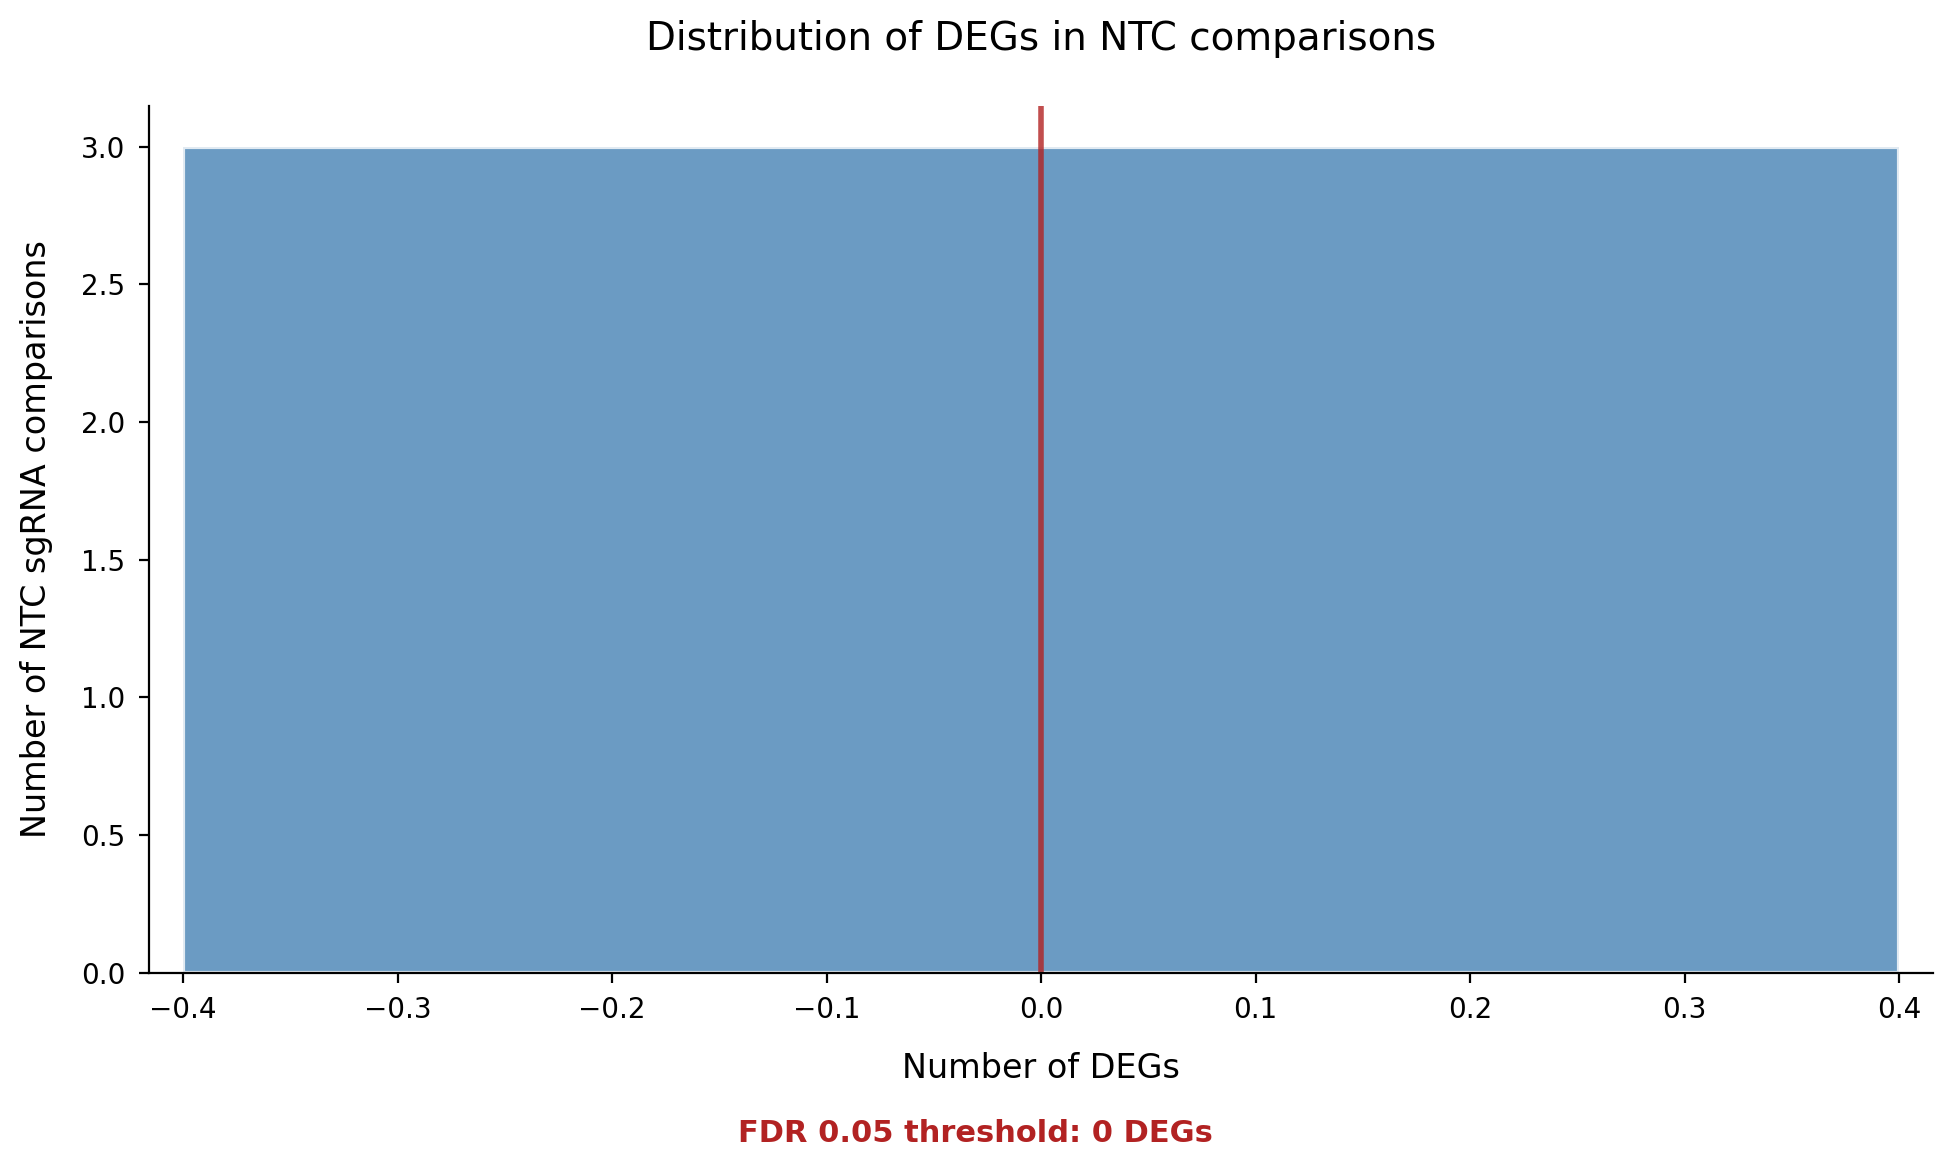

2025-10-30 14:00:58 - WARNING - Could not determine DEG count column. FDR significance column not added.


In [7]:
pipeline_test_adata = adata.copy()
pipeline_ntc_benchmark_results = \
    psp.de.benchmark_NTC_FDR(pipeline_test_adata, debug=True)

2025-10-30 14:04:50 - INFO - Using 13674 non-targeting control cells for benchmarking
2025-10-30 14:04:50 - INFO - Found 234 unique NTC sgRNAs


Benchmarking NTC sgRNAs:   0%|          | 0/234 [00:00<?, ?it/s]

/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:727: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:727: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:727: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:727: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:727: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:727: UserWarning:

2025-10-30 14:41:04 - INFO - Stored NTC FDR threshold (1) in adata.uns['ntc_fdr_threshold']
2025-10-30 14:41:04 - INFO - NTC Benchmark Statistics:
2025-10-30 14:41:04 - INFO -   • FDR 0.05 threshold: 1 DEGs
2025-10-30 14:41:04 - INFO -   • NTC comparisons analyzed: 234
2025-10-30 14:41:04 - INFO -   • Mean DEGs per comparison: 0.2
2025-10-30 14:41:04 - INFO -   • Median DEGs per comparison: 0.0
2025-10-30 14:41:04 - INFO -   • 95% of comparisons have < 1 DEGs


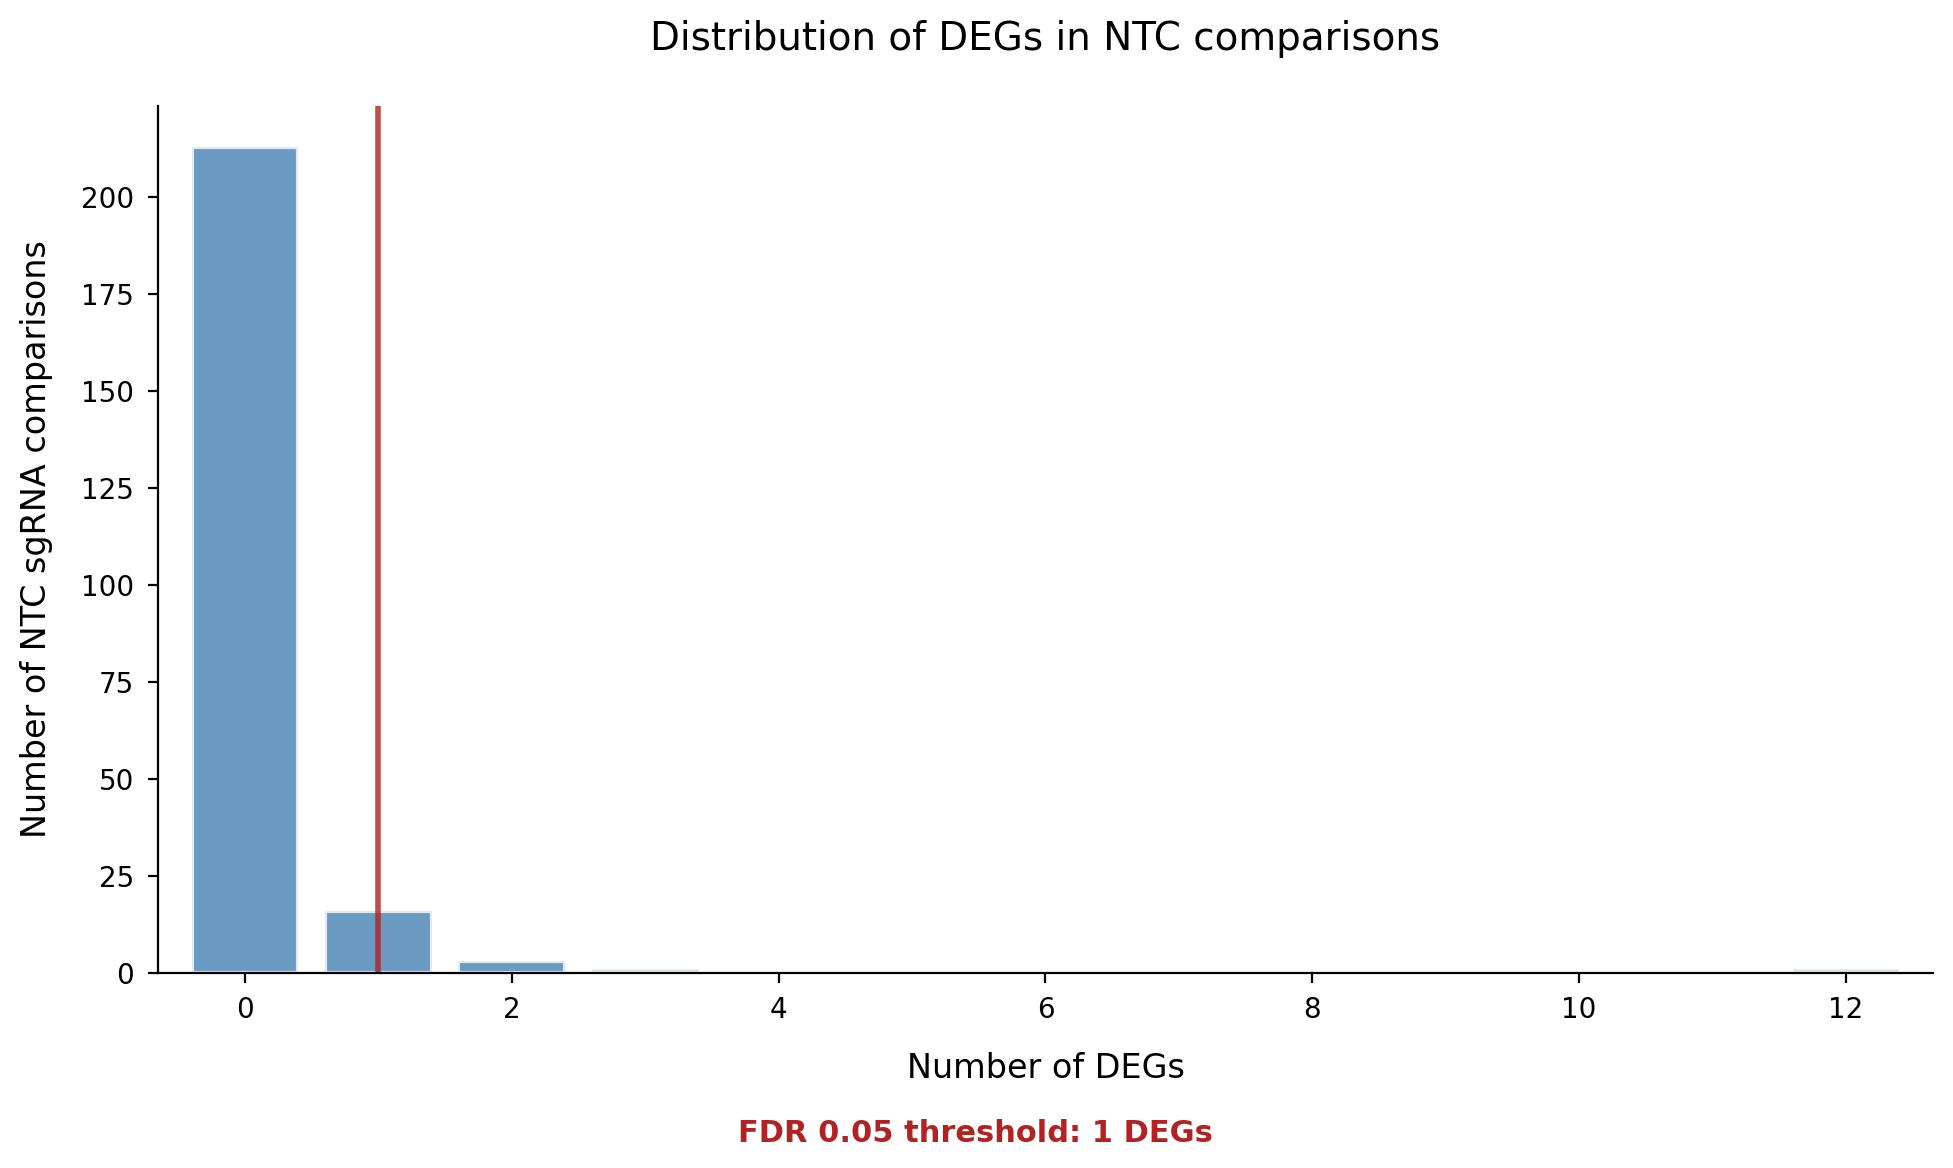

2025-10-30 14:41:04 - WARNING - Could not determine DEG count column. FDR significance column not added.


In [8]:
pipeline_adata = adata.copy()
pipeline_ntc_benchmark_results = \
    psp.de.benchmark_NTC_FDR(pipeline_adata)

In [14]:
pipeline_ntc_res = pipeline_ntc_benchmark_results[1]
pipeline_ntc_res.head()

,n_DEGs,sgRNA
key,,
Non-Targeting_516,12,Non-Targeting_516
Non-Targeting_254,3,Non-Targeting_254
Non-Targeting_334,2,Non-Targeting_334
Non-Targeting_863,2,Non-Targeting_863
Non-Targeting_415,2,Non-Targeting_415


In [17]:
ntc_gRNA_high_n_degs = pipeline_ntc_res.head().index.tolist()
print(ntc_gRNA_high_n_degs)

['Non-Targeting_516', 'Non-Targeting_254', 'Non-Targeting_334', 'Non-Targeting_863', 'Non-Targeting_415']


In [19]:
ntc_gRNA_n_cells = [adata[adata.obs.gRNA == gRNA].shape[0] for gRNA in ntc_gRNA_high_n_degs]
print(ntc_gRNA_n_cells)

[41, 56, 77, 65, 55]


In [15]:
pipeline_ntc_res["n_DEGs"].value_counts()

n_DEGs
0     213
1      16
2       3
12      1
3       1
Name: count, dtype: int64

# Old DE code

Write out results

In [ ]:
filepath_pkl = "/home/ranwyl/results_tf_project/DE_results_10_2_2025.pkl"
DE_results.to_pickle(filepath_pkl)

Rename genes that are listed by Ensembl ID but have a gene name

In [ ]:
all_genes = DE_results.index.tolist()
ensg_genes = [g for g in all_genes if g.startswith("ENSG")]
print(len(ensg_genes))
print(ensg_genes[:5])

In [ ]:
mg = get_client('gene')
ensembl_results_all = mg.querymany(ensg_genes, fields='symbol', species='human')

Manually search for the genes with duplicate hits on GeneCards. To break ties, use the highest GeneCards Inferred Functionality Score (GIFtS). If there is a tie between highest scoring gene symbols, keep the gene as its Ensembl ID.

In [ ]:
# Change this
dup_hits = {'ENSG00000234352': 'LOC349160', 'ENSG00000249738':'IL12B-AS1', 'ENSG00000257545':'LOC100287944'}

Rename genes

In [ ]:
ensembl_to_gene = dict()
for r in ensembl_results_all:
  if r.get('symbol'):
      ensembl_to_gene[r.get('query')] = r.get('symbol')
ensembl_to_gene.update(dup_hits) # Change duplicate hits
print(len(ensembl_to_gene))

In [ ]:
def rename_ensembl_genes(de_df, ensembl_to_gene_dict):
    """
    Rename genes in DataFrame.
    """
    de_df_renamed = de_df.rename(index=ensembl_to_gene_dict)
    print(f"Converted {len(ensembl_to_gene_dict)} Ensembl IDs to gene symbols")
    return de_df_renamed

In [ ]:
DE_results_renamed = rename_ensembl_genes(DE_results, ensembl_to_gene)

In [ ]:
filepath_pkl = "/home/ranwyl/results_tf_project/DE_results_gene_names_09-2025.pkl"
DE_results_renamed.to_pickle(filepath_pkl)